Purpose: Play Spot-It!

In [23]:
## General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import random
import time
import select
import sys

# Pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Image processing imports
import cv2
from PIL import Image

In [24]:
sys.path.append('model_related')
from model import CLASS_LABEL_DICT, CNN1
from card_processing import get_icons, display_card
from check_truth import extract_card_number, check_matches

SYMBOL_LIST = [
    "do_not_enter", "target", "lightning", "clown", "sunglasses", "spider", 
    "anchor", "tree", "web", "cat", "bomb", "lock", "hand", "apple", 
    "ghost", "man", "car", "moon", "eye", "clock", "scissors", "dinosaur", 
    "splat", "key", "dog", "pencil", "exclamation", "knight", "cactus", 
    "dolphin", "candle", "zebra", "droplet", "leaf", "fire", "turtle", 
    "skull", "lips", "heart", "question", "cheese", "sun", "ladybug", 
    "snowflake", "treble", "ice", "igloo", "carrot", "lightbulb", "bird", 
    "clover", "daisy", "bottle", "yin_yang", "mallet", "dragon", "snowman"
]
CLIP_LIMIT = 4.0
BINARY_THRESHOLD = 200
SYM_CARD_SIZE_RATIO = 1/20

In [25]:
# Define & Load Model
model_path = join("model_related", "model_v4.pth")
model = CNN1(num_classes=len(CLASS_LABEL_DICT))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=57, bias=True)
  (small_dropout): Dropout(p=0.1, inplace=False)
  (large_dropout): Dropout(p=0.3, inplace=False)
)

In [26]:
def model_move(model_card, shared_icons, shared_contours):
    model_icons, model_contours = get_icons(model_card, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
    model_matches = [item for item in model_icons if item in shared_icons]
    if model_matches:
        model_match = model_matches[0]
    else:
        return None
    model_contour = model_contours[model_icons.index(model_match)]
    shared_contour = shared_contours[shared_icons.index(model_match)]
    return model_match, model_contour, shared_contour

def ground_truth_match(user_card, shared_icons, shared_contours):
    user_icons, user_contours = get_icons(user_card, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
    actual_matches = [item for item in user_icons if item in shared_icons]
    if actual_matches:
        actual_match = actual_matches[0]
    else:
        return None
    user_contour = user_contours[user_icons.index(actual_match)]
    shared_contour = shared_contours[shared_icons.index(actual_match)]
    return actual_match, user_contour, shared_contour

['card42_01.tif', 'card22_01.tif', 'card27_01.tif', 'card15_01.tif', 'card24_01.tif', 'card02_01.tif', 'card10_01.tif', 'card17_01.tif', 'card06_01.tif', 'card13_01.tif', 'card53_01.tif', 'card25_01.tif', 'card40_01.tif', 'card26_01.tif', 'card38_01.tif', 'card44_01.tif', 'card47_01.tif', 'card08_01.tif', 'card19_01.tif', 'card01_01.tif', 'card21_01.tif', 'card29_01.tif', 'card09_01.tif', 'card03_01.tif', 'card18_01.tif', 'card07_01.tif', 'card45_01.tif', 'card35_01.tif', 'card43_01.tif', 'card37_01.tif', 'card51_01.tif', 'card11_01.tif', 'card33_01.tif', 'card41_01.tif', 'card16_01.tif', 'card32_01.tif', 'card48_01.tif', 'card50_01.tif', 'card28_01.tif', 'card05_01.tif', 'card39_01.tif', 'card31_01.tif', 'card52_01.tif', 'card36_01.tif', 'card12_01.tif', 'card55_01.tif', 'card30_01.tif', 'card46_01.tif', 'card14_01.tif', 'card49_01.tif', 'card23_01.tif', 'card04_01.tif', 'card54_01.tif', 'card20_01.tif', 'card34_01.tif']


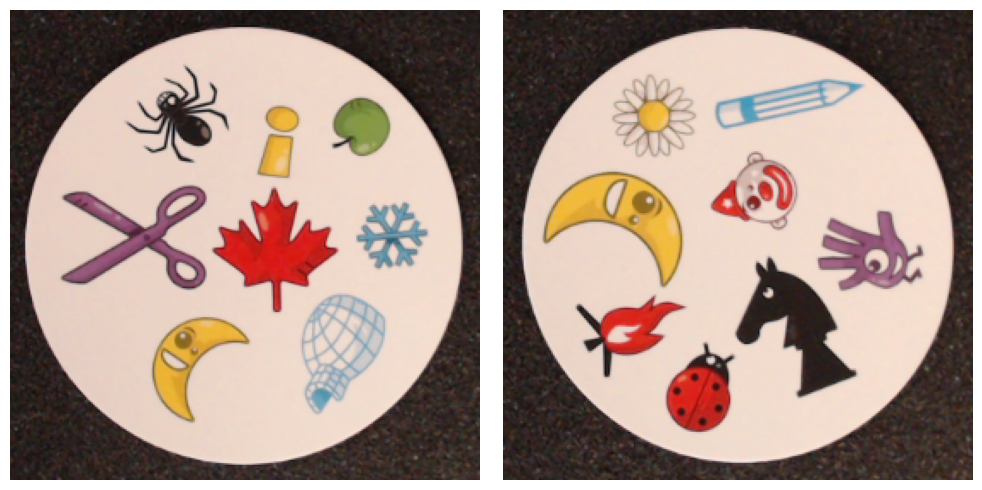

Correct!
Issue finding contours
Get new shared card


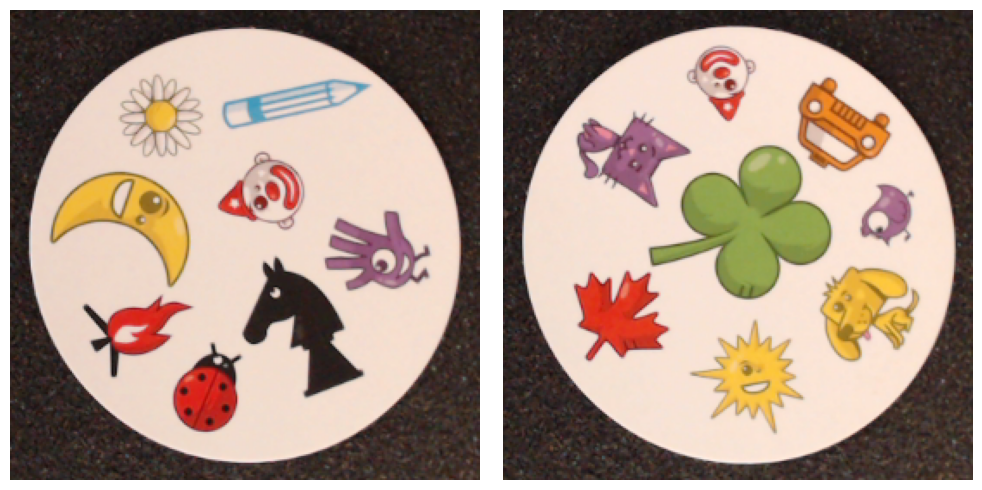

Correct!
Issue finding contours
Get new shared card


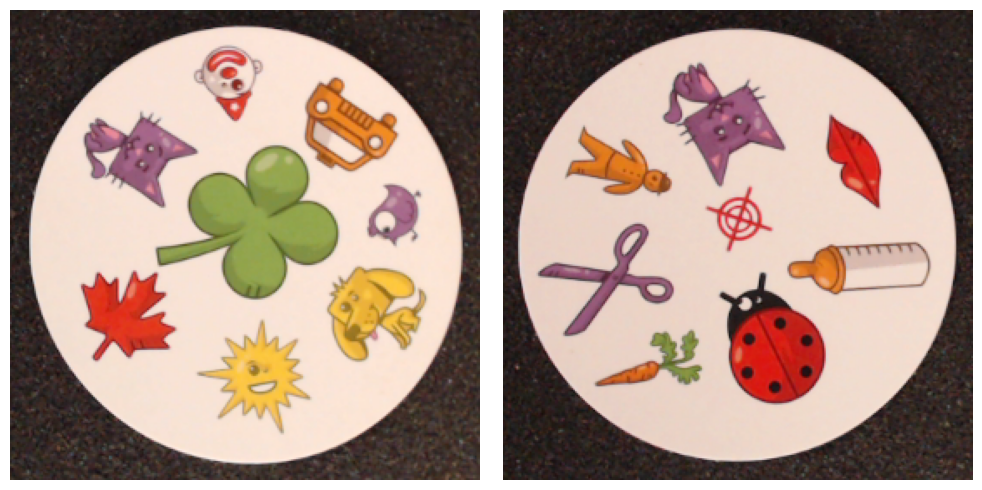

Model Wins!
Model Matching


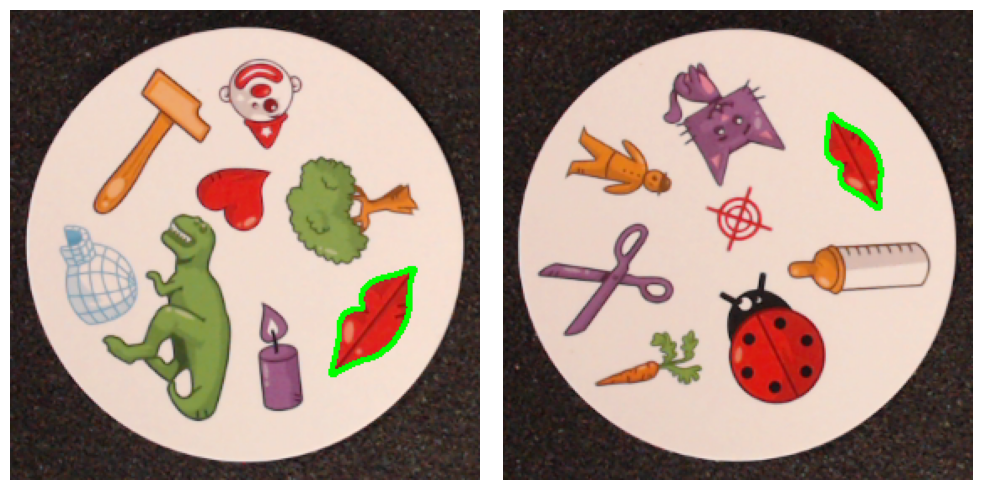

Actual User Match
cat


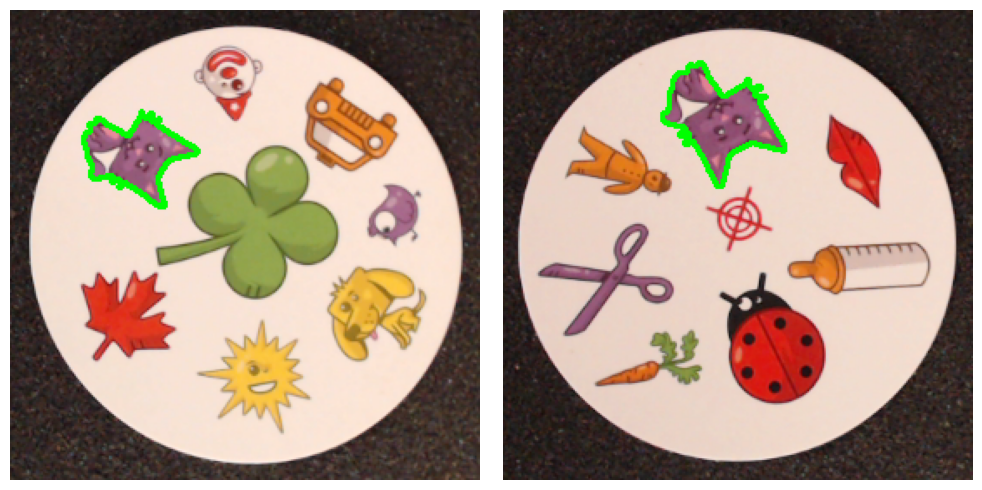

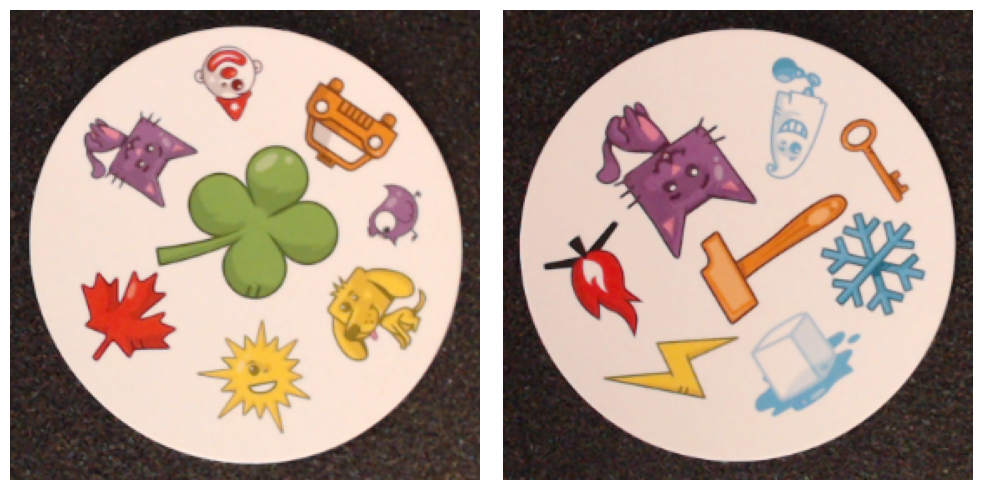

Correct!
Issue finding contours
Get new shared card


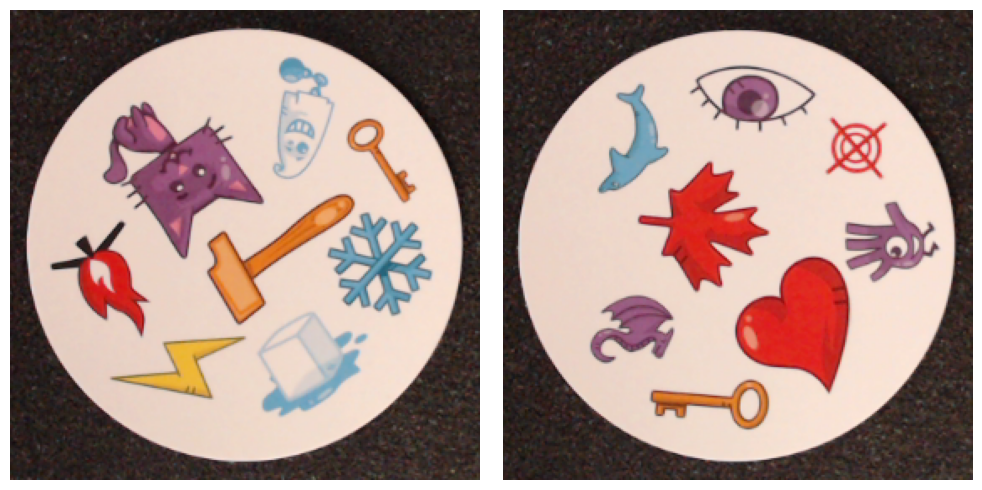

Game Ended
Your Score: 3
Model Score: 1


In [27]:
# Initialize game variables
cards = os.listdir("dobble_deck08_cards_55")
random.shuffle(cards)
# make smaller deck for easier testing
print(cards)
user_card_idx = extract_card_number(cards[0])
user_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
cards.pop(0)
model_card_idx = extract_card_number(cards[0])
model_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
cards.pop(0)
shared_card_idx = extract_card_number(cards[0])
shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
cards.pop(0)

user_score = 0
model_score = 0
# Game loop
while len(cards) > 0:
    # Get shared icons and contours
    shared_icons, shared_contours = get_icons(shared_card, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
    
    if model_move(model_card, shared_icons, shared_contours) is None or model_move(user_card, shared_icons, shared_contours) is None:
        print("Issue finding contours")
        print("Get new shared card")
        shared_card_idx = extract_card_number(cards[0])
        shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
        cards.pop(0)
        continue

    # Use ground truth for user and model matches
    model_match, model_contour, model_shared_contour = model_move(model_card, shared_icons, shared_contours)
    user_match, user_contour, user_shared_contour = ground_truth_match(user_card, shared_icons, shared_contours)
    
    # Display user card and shared card initially
    display_card(user_card, shared_card, None, None)
    
    user_true_match, model_true_match = check_matches(user_card_idx, shared_card_idx, model_card_idx)
    player_input = input("Enter the match: ")
    while player_input not in SYMBOL_LIST and player_input != "quit":
        player_input = input("Invalid symbol name, please try again: ")
    if player_input == "quit":
        print("Game Ended")
        break
    elif player_input == user_true_match:
        # If the user wins this round
        print("Correct!")
        user_card = shared_card
        user_card_idx = shared_card_idx
        user_score += 1
        time.sleep(0.5)
        # break
    elif model_match == model_true_match:
        print("Model Wins!")
        print("Model Matching")
        display_card(model_card, shared_card, model_contour, model_shared_contour)
        print("Actual User Match")
        print(user_true_match)
        display_card(user_card, shared_card, user_contour, user_shared_contour)
        model_card = shared_card
        model_card_idx = shared_card_idx
        model_score += 1
        time.sleep(0.5)
        # break
    else:
        print("Your guess was incorrect but so was the model's. The real match was", user_true_match)
        print("Actual Match")
        print(user_true_match)
        display_card(user_card, shared_card, user_contour, user_shared_contour)


    # Update shared card
    shared_card_idx = extract_card_number(cards[0])
    shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
    cards.pop(0)
if len(cards) == 0:
    print("No more cards left in the deck!")
print(f"Your Score: {user_score}")
print(f"Model Score: {model_score}")